# Frequency-Severity modelling

 $Claim Frequency = Claim Count / Exposure$
 
 $Claim Severity = Loss / Claim Count$
 
 It is a common actuarial assumption that: Claim Frequency has an over-dispersed Poisson distribution, whilst Claim Severity has a Gamma distribution.
 
 In this notebook we will apply General Linear Modelling (GLM) to estimate claim frequency and severity for auto-insurance data. We will be using the Pdummy_xyhon statsmodels package, that provides an example on GLM's [here](https://www.statsmodels.org/stable/examples/notebooks/generated/glm.html).


[*Frequency Severity Modelling vs Loss Cost. 2012. Yan, J. 2010 CAS Ratemaking and Product Management  Seminar (CASACT)*](https://www.casact.org/education/rpm/2012/handouts/Session_4738_presentation_1068_0.pdf)

In [1]:
import urllib.request
import shutil
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import Image
from IPython.core.display import HTML 

from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy import stats
from patsy import dmatrices,dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Load [dataOhlsson](https://cran.r-project.org/web/packages/insuranceData/insuranceData.pdf#Rfn.dataOhlsson.1)

A data frame with 64548 observations on the following 9 variables.
 1. (0:2) agarald - The owners age, between 0 and 99, a numeric vector.
 1. (2:3) kon - The owners age, between 0 and 99, a factor with levelsK M
 1. (3:4) zon - Geographic zone numbered from 1 to 7, in a standard classification of all Swedish parishes, anumeric vector
 1. (4:5) mcklass - MC class, a classification by the so called EV ratio, defined as (Engine power in kW x100) / (Vehicle weight in kg + 75), rounded to the nearest lower integer. The 75 kg represents the average driver weight. The EV ratios are divided into seven classes, a numeric vector
 1. (5:7) fordald - Vehicle age, between 0 and 99, a numeric vector
 1. (7:8) bonuskl - Bonus class, taking values from 1 to 7. 
  - A new driver starts with bonus class 1. For each claim free year the bonus class is increased by 1. 
  - After the first claim the bonus is decreased by  2. The  driver  can  not  return  to  class  7  with  less  than  6  consecutive  claim  free  years,  a numeric vector
 1. (8:16) duration - the number of policy years, a numeric vector
 1. (16:20) antskad - the number of claims, a numeric vector
 1. (20:) skadkost - the claim cost, a numeric vector

- *(n:n) are the columnar positions of the data*
- *data avaliable [here](https://staff.math.su.se/esbj/GLMbook/case.html)*

In [2]:
# read or get file
file_name='mccase.txt'

try: 
    file = open(file_name,'r')
except:
    url = 'https://staff.math.su.se/esbj/GLMbook/mccase.txt'
    # Download the file from `url` and save it locally under `file_name`:
    with urllib.request.urlopen(url) as response, open(file_name, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
    file = open(file_name,'r')

# load file
dat = list()
for line in file.readlines():
    dat.append([line[:2],line[2:3],line[3:4],line[4:5],line[5:7],line[7:8],line[8:16],line[16:20],str(line[20:]).replace('\n','')])
file.close()
df = pd.DataFrame(dat,columns=['Age','Sex','Geog','EV','VehAge','NCD','PYrs','Claims','Severity'])
df = df.astype({'Age':float,'Sex':'category','Geog':'category','EV':'category',
                'VehAge':int,'NCD':'category','PYrs':float,'Claims':int,'Severity':float}).copy()

# PYrs is the fraction of compelete policy years 
# there are some policies with 0.0 duration (1/365 = 0.00274 = 1 day)
# set these to 1 day
df.loc[df['PYrs']==0.0,'PYrs'] = 1.0/365.0

print(df.dtypes)

Age          float64
Sex         category
Geog        category
EV          category
VehAge         int32
NCD         category
PYrs         float64
Claims         int32
Severity     float64
dtype: object


***EDA***

- low number of claims and frequency (1% freq)

In [3]:
df.describe()

,Age,VehAge,PYrs,Claims,Severity
count,64548.000000,64548.000000,64548.000000,64548.000000,64548.000000
mean,42.416062,12.540063,1.010759,0.010798,264.017785
std,12.980960,9.727445,1.307356,0.107323,4694.693604
min,0.000000,0.000000,0.002740,0.000000,0.000000
25%,31.000000,5.000000,0.463014,0.000000,0.000000
50%,44.000000,12.000000,0.827397,0.000000,0.000000
75%,52.000000,16.000000,1.000000,0.000000,0.000000
max,92.000000,99.000000,31.339730,2.000000,365347.000000


In [4]:
claims = df.loc[df['Claims']!=0]
claims.describe()

,Age,VehAge,PYrs,Claims,Severity
count,670.000000,670.000000,670.000000,670.000000,670.000000
mean,35.476119,7.965672,1.579415,1.040299,25435.552239
std,12.851056,6.768896,2.983317,0.196805,38539.415033
min,16.000000,0.000000,0.002740,1.000000,16.000000
25%,25.000000,2.000000,0.430137,1.000000,3031.500000
50%,30.000000,7.000000,0.790411,1.000000,9015.000000
75%,47.000000,12.000000,1.497945,1.000000,29304.500000
max,68.000000,55.000000,31.167120,2.000000,365347.000000


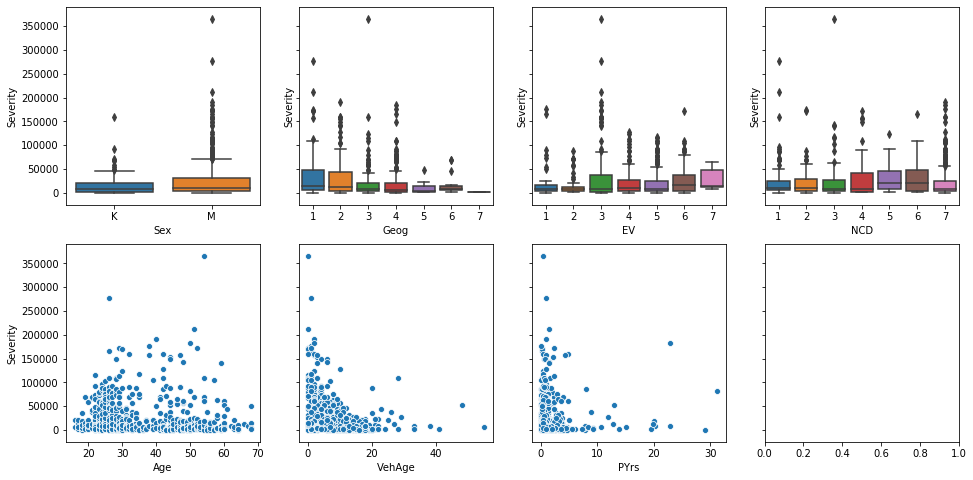

In [5]:
fig,axs=plt.subplots(2,4,figsize=(16,8),sharey=True)
for col,ax in zip(df.select_dtypes(include='category').columns,axs.flatten()):
    sns.boxplot(x=col,y='Severity',data=claims,ax=ax)

for col,ax in zip(['Age','VehAge','PYrs'],axs.flatten()[4:]):
    sns.scatterplot(x=col,y='Severity',data=claims,ax=ax)

# Modelling
- StatsModels (SM) uses patsy [formula notation](https://www.statsmodels.org/devel/example_formulas.html).
- This includes: [notation for categorical variables ](https://www.statsmodels.org/devel/contrasts.html), setting [reference/base levels](https://stackoverflow.com/a/22439820/4538066), [encoding options](https://www.statsmodels.org/devel/contrasts.html), and [operators](https://www.statsmodels.org/devel/example_formulas.html#categorical-variables).

In [6]:
# single claim frequency indicator
df['Claim'] = (df['Claims']>=1).astype(int)

# train-test splits stratifies on claims
# take copies to overcome chained assignment
train,test = train_test_split(df,test_size=0.3,random_state=1990,stratify=df['Claim'])
train = df.loc[train.index].copy()
test = df.loc[test.index].copy()

### $Claim Frequency$

For predicting the occurence of a single claim (i.e. binary classification) one can use the Binomial distribution (a.k.a Bernoulli trial or coin-toss experiment).

When predicting claim counts or frequency, $Y$, a model that prodices Poisson distributed outputs is required. For instance, a Poisson model is suitable for estimating the number of insurance claims per policy per year, or to estimate the number of car crashes per month. 

The key components and assumptions of a Poisson distributed process are: 
 1. event occurence is independant of other events. 
 1. events occur within a fixed period of time.
 1. the mean a variance of the distribution are equal e.g. $mu(X) = Var(X) = λ$
 
[*STAT 504: Poisson Distribution*](https://online.stat.psu.edu/stat504/node/57/)


If the mean and variance are unequal the distribution is said to be over-disperesed (var > mean) or under-dispersed (var < mean). Over-dispersion commonly arises in data where there are large number of zero's (a.k.a [zero-inflated](https://en.wikipedia.org/wiki/Zero-inflated_model)).

In the case of zero-inflated data, it is "*A sound practice is to estimate both Poisson and negative binomial models.*" [*Cameron, 2013*](http://faculty.econ.ucdavis.edu/faculty/cameron/racd2/). Also see this practical example for [beverage consumption in pdummy_xyhon](https://dius.com.au/2017/08/03/using-statsmodels-glms-to-model-beverage-consumption/)

In GLM's, link-functions are applied in order to make the mean outcome (prediction) fit to some linear model of input variables from other distributions. "*A natural fit for count variables that follow the Poisson or negative binomial distribution is the log link. The log link exponentiates the linear predictors. It does not log transform the outcome variable.*" - [*Count Models: Understanding the Log Link Function,TAF*](https://www.theanalysisfactor.com/count-models-understanding-the-log-link-function/)

For more information on link-functions see also [here](https://bookdown.org/castillo_sam_d/Exam-PA-Study-Manual/glms-for-classification.html#link-functions).

![link functions](https://i0.wp.com/www.theanalysisfactor.com/wp-content/uploads/2016/12/StataCombos-CM2-Blog-JM.png?w=535&ssl=1)

Lastly, for any form of count prediction model one can also set an offset or exposure. 

An offset, if it is known, is applied in order to account for the relative differences in exposure time for of a set of inputs. For example, in insurance claims we might expect to see more claims on an account with 20 years worth of annual policies compared to an account with a single policy year. Offsets account for the relative exposure|surface area|population size|etc and is akin to the relative frequency of occurence ($Claims/years$). See these intuititve SO answers [here](https://stats.stackexchange.com/questions/232666/should-i-use-an-offset-for-my-poisson-glm), [here](https://github.com/statsmodels/statsmodels/issues/1486#issuecomment-40945831), and [here](https://stats.stackexchange.com/questions/25415/using-offset-in-binomial-model-to-account-for-increased-numbers-of-patients).

In [7]:
# Mean & Variance
mu = df.Claims.mean()
var = np.mean([abs(x - mu)**2 for x in df.Claims])
print(f'mu =  {mu:.4f}\nvar = {var:.4f}')

mu =  0.0108
var = 0.0115


Here we observe an over-dispersed zero-inflated case as the variance of claim occurence ($v=0.0115$) exceeds its mean ($mu=0.0108$).

As suggested in Cameron (2013) we should therefore try both $Poisson$ and $Negative Binomial$ distributions. For good measure, and to illustrate its relationship, lets also include a $Binomial$ distribution model given that the number of accounts with claims $n>1$ is low (22) and as the $Binomial$ distribution extends to a $Poisson$ when trials $N>20$ is high and $p<0.05$ is low (see [wiki](https://en.wikipedia.org/wiki/Poisson_distribution#Related_distributions), [here](https://math.stackexchange.com/questions/1050184/difference-between-poisson-and-binomial-distributions) and [here](https://www.itl.nist.gov/div898/handbook/pmc/section3/pmc331.htm)).

In [8]:
# # examples of formula notation in smf
# print(' + '.join(train.columns))
# expr = "Claims ~ Age+C(Sex)+C(Geog, Treatment(reference=3))+EV+VehAge+NCD"

# including PYrs as parameter commented out in glm()
expr = "Claims ~ Age + Sex + Geog + EV + VehAge + NCD " # + np.log(PYrs)

FreqPoisson = smf.glm(formula=expr,
                      data=train,
                      offset=np.log(train['PYrs']),
                      family=sm.families.Poisson(link=sm.families.links.log())).fit()

FreqNegBin = smf.glm(formula=expr,
                      data=train,
                      offset=np.log(train['PYrs']),
                      family=sm.families.NegativeBinomial(link=sm.families.links.log())).fit()

# use binary "Claim"
FreqBinom = smf.glm(formula="Claim ~ Age + Sex + Geog + EV + VehAge + NCD " ,
                      data=train,
                      offset=np.log(train['PYrs']),
                      family=sm.families.Binomial(link=sm.families.links.log())).fit()

LogitReg = smf.glm(formula="Claim ~ Age + Sex + Geog + EV + VehAge + NCD " ,
                    data=train,
                    #offset=np.log(train['PYrs']),
                    family=sm.families.Binomial()).fit()

print(FreqPoisson.summary())
print(FreqNegBin.summary())
print(FreqBinom.summary())
print(LogitReg.summary())

C:\ProgramData\Anaconda3\envs\machine-learning\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:273: DomainWarning: The log link function does not respect the domain of the Binomial family.
  DomainWarning)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Claims   No. Observations:                45183
Model:                            GLM   Df Residuals:                    45161
Model Family:                 Poisson   Df Model:                           21
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2541.7
Date:                Wed, 07 Oct 2020   Deviance:                       4135.6
Time:                        20:31:04   Pearson chi2:                 1.83e+05
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9052      0.284     -3.184      0.0

#### coefficients

- Negative binomial coefficients and incidence rate ratio
 - https://stats.idre.ucla.edu/stata/dae/negative-binomial-regression/
 - https://stats.stackexchange.com/questions/17006/interpretation-of-incidence-rate-ratios
 - https://stats.stackexchange.com/questions/414752/how-to-interpret-incidence-rate-ratio
 - https://www.cdc.gov/csels/dsepd/ss1978/lesson3/section5.html

C:\ProgramData\Anaconda3\envs\machine-learning\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


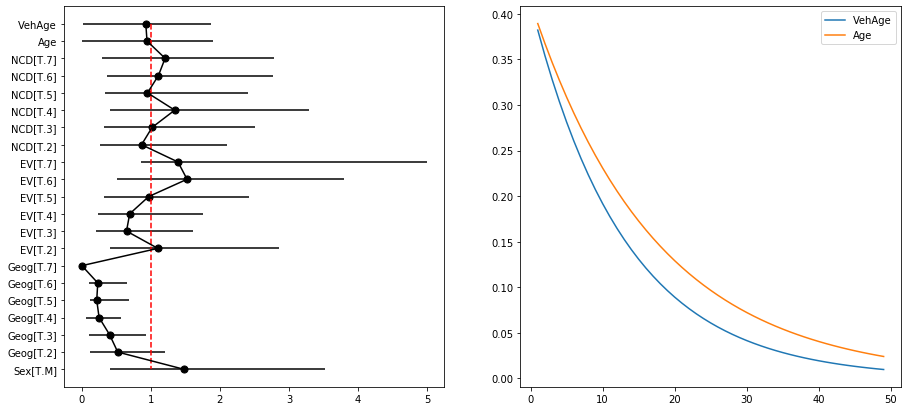

In [9]:
X_ = np.arange(0,len(FreqNegBin.params[1:]))
irr_ = np.exp(FreqNegBin.params[1:])
frq_ = [np.exp(FreqNegBin.params[0]+x) for x in FreqNegBin.params[1:]]
df_ = pd.DataFrame({'X':X_,'irr':irr_,'frq':frq_})
df_['lwr'] = np.exp(FreqNegBin.conf_int()[0])
df_['upr'] = np.exp(FreqNegBin.conf_int()[1])

fig,axs = plt.subplots(1,2,figsize=(15,7))
ages_ = np.arange(1,50,1)

axs[0].scatter(x=df_.irr,y=df_.X,s=50,c='k')
axs[0].errorbar(x=df_.irr,y=df_.X,xerr=(df_.lwr,df_.upr),c='k')
axs[0].plot([1,1],[20,0],'r--')
axs[0].set_yticks(df_.X)
axs[0].set_yticklabels(irr_.index)

axs[1].plot(ages_,[np.exp(FreqNegBin.params[0]+FreqNegBin.params['VehAge']*i) for i in ages_],label='VehAge')
axs[1].plot(ages_,[np.exp(FreqNegBin.params[0]+FreqNegBin.params['Age']*i) for i in ages_],label='Age')
axs[1].legend();

#### predictions


,Age,Sex,Geog,EV,VehAge,NCD,PYrs,Claims,Severity,Claim,Fnb,Fbi,Fpo,FLR
35445,45.0,M,4,6,2,7,4.920548,1,2480.0,1,0.086536,0.077532,0.084589,0.032506
9653,26.0,M,6,6,9,5,0.589041,1,46000.0,1,0.013288,0.011206,0.013069,0.007993
2039,21.0,M,2,2,19,1,0.432877,1,11110.0,1,0.010413,0.010263,0.010307,0.013808
7824,25.0,M,4,6,9,7,3.542466,1,35900.0,1,0.116454,0.105764,0.113842,0.049767


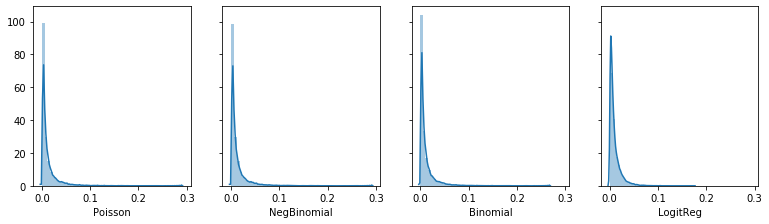

In [10]:
test['Fnb'] = FreqNegBin.predict(transform=True,exog=test,offset=np.log(test['PYrs']))
test['Fbi'] = FreqBinom.predict(transform=True,exog=test,offset=np.log(test['PYrs']))
test['Fpo'] = FreqPoisson.predict(transform=True,exog=test,offset=np.log(test['PYrs']))
test['FLR'] = LogitReg.predict(transform=True,exog=test)#,offset=np.log(test['PYrs']))

fig,axs = plt.subplots(1,4,figsize=(13,3.3),sharex=True,sharey=True)
sns.distplot(test['Fpo'],ax=axs[0],axlabel='Poisson')
sns.distplot(test['Fnb'],ax=axs[1],axlabel='NegBinomial')
sns.distplot(test['Fbi'],ax=axs[2],axlabel='Binomial')
sns.distplot(test['FLR'],ax=axs[3],axlabel='LogitReg')

test.loc[test['Claim']>0][:4]

Loooking at the model summaries, the histograms and results the of predicted values on the test, we see that each model weights covariates similarly and produces similar scores on the test data. ***Again note*** that the $Binomial$ model was only used to demonstrate its similarity in this case, but this may not hold for other data.

# Poisson Params
- [Poisson GLM params](https://stackoverflow.com/questions/14923684/interpreting-the-output-of-glm-for-poisson-regression)
- [Find lambda](https://stackoverflow.com/questions/25828184/fitting-to-poisson-histogram)

In [11]:
# sim data
#np.random.seed(1066)
n = 10000
y =np.random.poisson(lam=0.25,size=n)
dummy_xy = pd.DataFrame({'Y':y,
                   #'B':pd.cut(pd.Series(y),bins=[0,0.5,1,10],right=True,labels=[0,1,2]),
                   'B':np.random.exponential(scale=1,size=n)
                  })

#### estimate params using MLE fit
# print(stats.poisson.fit(dummy_xy['Y']))

### Estimate scale (rate) using GLM-poisson with default log link
glm = smf.glm("Y ~ 1 + B", data=dummy_xy,family=sm.families.Poisson()).fit()
glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6053.5
Date:                Wed, 07 Oct 2020   Deviance:                       7673.0
Time:                        20:31:06   Pearson chi2:                 1.01e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3828      0.029    -48.369      0.000      -1.439      -1.327
B             -0.0385      0.021     -1.820      0.069      -0.080       0.003
==============================================================================
"""

Lambda intercept: 0.25087541154451143
Lambda B=i: 0.17073777593032222


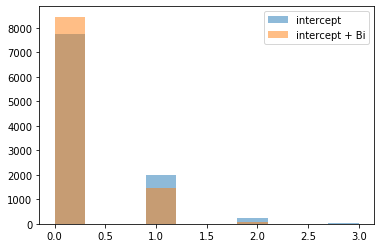

In [12]:
fig,axs = plt.subplots(1,1)
i = 10
print(f'Lambda intercept: {np.exp(glm.params[0])}\nLambda B=i: {np.exp(glm.params[0]+glm.params[1]*i)}')
axs.hist(np.random.poisson(lam=np.exp(glm.params[0]),size=n),alpha=0.5,label='intercept', align='mid')
axs.hist(np.random.poisson(lam=np.exp(glm.params[0]+glm.params[1]*i),size=n),alpha=0.5,label='intercept + Bi',align='mid')
axs.legend();

***poisson conifdence intervals***

In [13]:
t = glm.get_prediction(dummy_xy)
t.summary_frame(alpha=0.001)[:2]

,mean,mean_se,mean_ci_lower,mean_ci_upper
0,0.250793,0.007138,0.228371,0.275415
1,0.201519,0.020624,0.143901,0.282208


# Gamma Params
***After fitting a GLM-Gamma, how do we find the Gamma shape ($a$) and scale ($b$) params of predictions for $Xi$?***

"*Regression with the gamma model is going to use input variables Xi and coefficients to make a pre-diction about the mean of yi, but in actuality we are really focused on the scale parameter βi.  This is so because we assume that αi is the same for all observations, and so variation from case to case in μi=βiα is due simply to variation in βi.*" [technical overview of gamma glm](https://pj.freefaculty.org/guides/stat/Regression-GLM/Gamma/GammaGLM-01.pdf)

- [gamma handout](https://pj.freefaculty.org/guides/stat/Distributions/DistributionWriteups/Gamma/Gamma-02.pdf)
- [Gamma Choice of link function](http://people.stat.sfu.ca/~raltman/stat402/402L26.pdf)
- [exmaple finding scale in R](https://stat.ethz.ch/pipermail/r-help/2011-July/283736.html)
- [generalized linear model - Dispersion parameter for Gamma family - Cross Validated](https://stats.stackexchange.com/questions/247624/dispersion-parameter-for-gamma-family)
- [Pdummy_xyhon: Calculating scale/dispersion of Gamma GLM using statsmodels](https://stackoverflow.com/questions/60215085/calculating-scale-dispersion-of-gamma-glm-using-statsmodels)


[Alternatively Infer gamma params from CI](https://math.stackexchange.com/questions/2873763/is-it-possible-to-determine-shape-and-scale-for-a-gamma-distribution-from-a-mean?newreg=d61b4517cd304ecca335b8e69220bf0c)


- [gamma.shape.glm: Estimate the Shape Parameter of the Gamma Distribution R MASS](https://rdrr.io/cran/MASS/man/gamma.shape.glm.html)
- [The identity link function does not respect the domain of the Gamma family? - Cross Validated](https://stats.stackexchange.com/questions/356053/the-identity-link-function-does-not-respect-the-domain-of-the-gamma-family)

In [14]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

***Dummy data***

In [15]:
# sim data
#np.random.seed(1066)
y = np.random.gamma(shape=2, scale=3, size=10_000)
dummy_xy = pd.DataFrame({'Y':y,
                         'category':pd.cut(pd.Series(y),bins=[0,3,7,10,5000],right=True,labels=[1,2,3,4]),
                         'numerical':pd.Series(y * np.random.random(size=10000))
                  })

if dummy_xy.isnull().any().any():
    print('Nulls')

***MLE parameter estimations on raw data***

In [16]:
#### estimate params using MLE fit
print(stats.gamma.fit(dummy_xy['Y']))

(2.0560810007601624, -0.011730752253083863, 2.9471441248735464)


***GLM-Gamma Inverse-Power link***

Shape : 13.420435018430842
Scale X0:  0.13647296613862783
Scale Xi:  0.35158505451211275
Scale Xi:  0.5859911600401488


C:\ProgramData\Anaconda3\envs\machine-learning\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:273: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


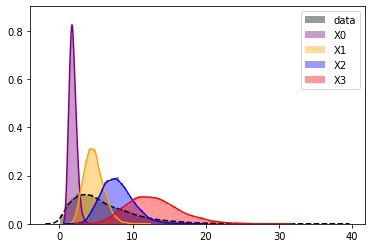

In [17]:
### Estimate scale (rate) using GLM-gamma with default inverse-power link
glm = smf.glm("Y ~ 1 + category + numerical", data=dummy_xy,family=sm.families.Gamma())
glm_fit = glm.fit()

# shape is
shape = 1/glm_fit.scale
print('Shape :',shape)

# Remeber we drop a reference category for modelling
# For each categorical level
# intercept scale is
X0 = glm_fit.scale/glm_fit.params[0]
print('Scale X0: ',X0)


# scale for each categorical value is
X1 = glm_fit.scale/(glm_fit.params[0]+glm_fit.params[1])
print('Scale Xi: ',X1)
X2 = glm_fit.scale/(glm_fit.params[0]+glm_fit.params[2])
print('Scale Xi: ',X2)

# and for the numerical when 
# category = 2
# numerical = max
X3 = glm_fit.scale/(glm_fit.params[0]+glm_fit.params[2]+glm_fit.params['numerical']*dummy_xy['numerical'].max())

# plot
sns.distplot(y,color='black',label='data',kde_kws={'linestyle':'--'})
sns.distplot(np.random.gamma(shape=shape,scale=X0,size=10000),color='purple',label='X0')
sns.distplot(np.random.gamma(shape=shape,scale=X1,size=10000),color='orange',label='X1')
sns.distplot(np.random.gamma(shape=shape,scale=X2,size=10000),color='blue',label='X2')
sns.distplot(np.random.gamma(shape=shape,scale=X3,size=10000),color='red',label='X3')
plt.legend();

In [18]:
glm_fit.params

Intercept        0.545993
category[T.2]   -0.334057
category[T.3]   -0.418835
category[T.4]   -0.459100
numerical       -0.001840
dtype: float64

In [19]:
# So remember the model gives us the predicted mean value 
dummy_xy['pred-inv'] = glm_fit.predict()
dummy_xy[:5]

,Y,category,numerical,pred-inv
0,13.265070,4,3.341688,12.384684
1,7.234669,3,3.712670,8.310645
2,17.869884,4,12.361580,15.588103
3,4.742598,2,0.301769,4.730816
4,1.334626,1,0.444139,1.834271


In [20]:
# manually sampling this distribution and finding the mean will give us the prediction
scale = glm_fit.scale/(glm_fit.params[0]+glm_fit.params['category[T.2]']+glm_fit.params['numerical']*1.593)
sample = np.random.gamma(shape=shape,scale=scale,size=1000)
np.mean(sample)

4.743191639200301

In [21]:
print('Bingo!')

Bingo!


***GLM-Gamma log link***

- https://pj.freefaculty.org/guides/stat/Distributions/DistributionWriteups/Gamma/Gamma-02.pdf
- https://pj.freefaculty.org/guides/stat/Regression-GLM/Gamma/GammaGLM-01.pdf
- http://people.stat.sfu.ca/~raltman/stat402/402L26.pdf
- https://stats.stackexchange.com/questions/431120/how-to-interpret-parameters-of-glm-output-with-gamma-log-link
- https://seananderson.ca/2014/04/08/gamma-glms/


Shape : 13.678043590368727
Scale X0:  0.1268097352007653
Scale Xi:  0.04873430540996467
Scale Xi:  0.0364575419037852


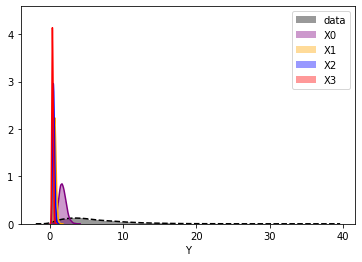

In [22]:
### Estimate scale (rate) using GLM-gamma with default inverse-power link
glm = smf.glm("Y ~ 1 + category + numerical", data=dummy_xy,family=sm.families.Gamma(link=sm.families.links.log()))
glm_fit = glm.fit()

# shape is 1/rate
shape = 1/glm_fit.scale
print('Shape :',shape)

# Remeber we drop a reference category for modelling
# For each categorical level
# intercept scale is
X0 = glm_fit.scale/glm_fit.params[0]
print('Scale X0: ',X0)


# scale for each categorical value is
X1 = glm_fit.scale/(glm_fit.params[0]+glm_fit.params[1])
print('Scale Xi: ',X1)
X2 = glm_fit.scale/(glm_fit.params[0]+glm_fit.params[2])
print('Scale Xi: ',X2)

# and for the numerical when 
# category = 2
# numerical = max
X3 = glm_fit.scale/(glm_fit.params[0]+glm_fit.params[2]+glm_fit.params['numerical']*dummy_xy['numerical'].max())

# plot
sns.distplot(dummy_xy.Y,color='black',label='data',kde_kws={'linestyle':'--'})
sns.distplot(np.random.gamma(shape=shape,scale=X0,size=10000),color='purple',label='X0')
sns.distplot(np.random.gamma(shape=shape,scale=X1,size=10000),color='orange',label='X1')
sns.distplot(np.random.gamma(shape=shape,scale=X2,size=10000),color='blue',label='X2')
sns.distplot(np.random.gamma(shape=shape,scale=X3,size=10000),color='red',label='X3')
plt.legend();

In [23]:
glm_fit.params

Intercept        0.576532
category[T.2]    0.923641
category[T.3]    1.428811
category[T.4]    1.831699
numerical        0.029367
dtype: float64

In [24]:
# So remember the model gives us the predicted mean value 
dummy_xy['pred-log'] = glm_fit.predict()
dummy_xy[:5]

,Y,category,numerical,pred-inv,pred-log
0,13.265070,4,3.341688,12.384684,12.260280
1,7.234669,3,3.712670,8.310645,8.284374
2,17.869884,4,12.361580,15.588103,15.978560
3,4.742598,2,0.301769,4.730816,4.522362
4,1.334626,1,0.444139,1.834271,1.803222


In [25]:
# dispersion aka rate
dispersion = glm_fit.scale
print('Disp',dispersion)

# shape is 1/dispersion
shape = 1/dispersion
print('Shape',shape)

# predicted mean G(Yi) is exp(Bo + Bi*Xi..)
# this is correctly getting the mean prediction
Yi = np.exp(glm_fit.params[0]+glm_fit.params['category[T.2]']+glm_fit.params['numerical']*1.59)
print('Yi',Yi)

# scale = Yi * dispersion
scale = Yi * dispersion
print('Scale',scale)

Disp 0.07310987082276453
Shape 13.678043590368727
Yi 4.696724852543148
Scale 0.3433769472594973


4.665748809551485


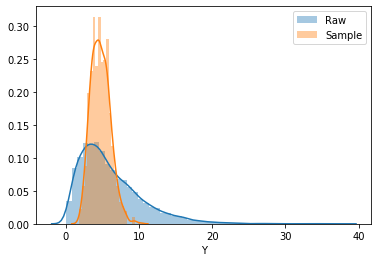

In [26]:
print(np.random.gamma(shape=shape,scale=scale,size=1000).mean())

sns.distplot(dummy_xy['Y'],label='Raw')
sns.distplot(np.random.gamma(shape=shape,scale=scale,size=1000),label='Sample')
plt.legend();

# Design Info
can we use design info to calculate the parameters for the whole dataset?

In [27]:
# use inverse-link as we know that this works
glm = smf.glm("Y ~ 1 + category + numerical", data=dummy_xy,family=sm.families.Gamma())
glm_fit = glm.fit()

C:\ProgramData\Anaconda3\envs\machine-learning\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:273: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


In [28]:
# data values
a = pd.DataFrame(glm.data.exog,columns=glm.data.param_names)[:3]
a

,Intercept,category[T.2],category[T.3],category[T.4],numerical
0,1.0,0.0,0.0,1.0,3.341688
1,1.0,0.0,1.0,0.0,3.712670
2,1.0,0.0,0.0,1.0,12.361580


In [29]:
# glm coefficients
b = pd.DataFrame(glm_fit.params).T
b

,Intercept,category[T.2],category[T.3],category[T.4],numerical
0,0.545993,-0.334057,-0.418835,-0.4591,-0.00184


In [30]:
# but this only works if indexes are equal
c = a.multiply(b,axis=0)
c

,Intercept,category[T.2],category[T.3],category[T.4],numerical
0,0.545993,-0.0,-0.0,-0.4591,-0.006148
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN


In [31]:
# we can also just use arrays et voila
c = pd.DataFrame(glm.data.exog[:10,:] * glm_fit.params.values,columns=glm.data.param_names)
c

,Intercept,category[T.2],category[T.3],category[T.4],numerical
0,0.545993,-0.000000,-0.000000,-0.4591,-0.006148
1,0.545993,-0.000000,-0.418835,-0.0000,-0.006830
2,0.545993,-0.000000,-0.000000,-0.4591,-0.022741
3,0.545993,-0.334057,-0.000000,-0.0000,-0.000555
4,0.545993,-0.000000,-0.000000,-0.0000,-0.000817
5,0.545993,-0.000000,-0.000000,-0.0000,-0.002673
6,0.545993,-0.000000,-0.000000,-0.0000,-0.000212
7,0.545993,-0.000000,-0.000000,-0.4591,-0.009128
8,0.545993,-0.000000,-0.000000,-0.4591,-0.011649
9,0.545993,-0.000000,-0.418835,-0.0000,-0.007325


Sample Mu 12.27, Predicted Mu 12.38
Sample Mu 8.27, Predicted Mu 8.31
Sample Mu 15.27, Predicted Mu 15.59
Sample Mu 4.71, Predicted Mu 4.73
Sample Mu 1.83, Predicted Mu 1.83
Sample Mu 1.82, Predicted Mu 1.84
Sample Mu 1.85, Predicted Mu 1.83
Sample Mu 12.62, Predicted Mu 12.86
Sample Mu 13.50, Predicted Mu 13.29
Sample Mu 8.39, Predicted Mu 8.34


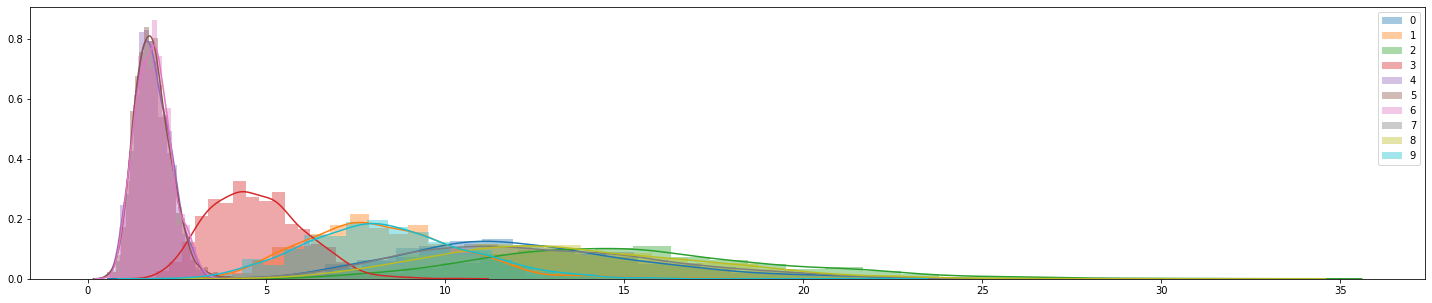

In [32]:
fig,axs = plt.subplots(1,1,figsize=(25,5))
for i,pred in zip(c.index,glm_fit.predict()[:10]):
    scale = glm_fit.scale/c.loc[[i]].sum(axis=1)
    sample = np.random.gamma(shape=1/glm_fit.scale,scale=scale,size=1000)
    sns.distplot(sample,label=i,ax=axs)
    print(f'Sample Mu {sample.mean():.2f}, Predicted Mu {pred:.2f}')
plt.legend();

***notes***

In [33]:
# inver link functions
# https://stats.stackexchange.com/a/393912/100439
glm_fit.predict(linear=True)

array([0.0807449 , 0.12032761, 0.06415149, ..., 0.54330735, 0.5457352 ,
       0.20792061])